# Credit Risk/Ratings Prediction

##### Aidan Cremins, Peyton Lewis, Joe Morris, Amrit Sandhu

### Necessary Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

### Get Data

#### Read in Credit Ratings

In [2]:
credit_ratings_file = "ratios_with_credit_ratings_all.csv"
all_data = pd.read_csv(credit_ratings_file)
all_data.dropna(inplace=True)

all_data.drop(all_data.columns[0], axis=1, inplace=True)
all_data["rating"] = all_data["long_term_credit_rating"].apply(lambda x: 1 if x[0] == "A" else (1 if x[0:3] == "BBB" else 0))

#### Test Train Split

In [3]:
all_data = pd.get_dummies(all_data, drop_first=True, columns=['gicdesc'])
print(all_data.columns)

Index(['gsector', 'public_date', 'ticker', 'roa', 'intcov_ratio',
       'quick_ratio', 'intcov', 'bm', 'npm', 'debt_assets', 'debt_ebitda',
       'inv_turn', 'cash_ratio', 'long_term_credit_rating', 'rating',
       'gicdesc_Consumer Discretionary', 'gicdesc_Consumer Staples',
       'gicdesc_Energy', 'gicdesc_Financials', 'gicdesc_Health Care',
       'gicdesc_Industrials', 'gicdesc_Information Technology',
       'gicdesc_Materials', 'gicdesc_Utilities'],
      dtype='object')


In [4]:
X = all_data.drop('rating', axis=1)
y = all_data['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

columnsOfInterest = ['gicdesc_Consumer Discretionary', 'gicdesc_Consumer Staples',\
       'gicdesc_Energy', 'gicdesc_Financials', 'gicdesc_Health Care',\
       'gicdesc_Industrials', 'gicdesc_Information Technology',\
       'gicdesc_Materials', 'gicdesc_Utilities', 'roa', 'intcov_ratio', \
        'quick_ratio', 'intcov', 'bm', 'npm', 'debt_assets', 'debt_ebitda', \
            'inv_turn', 'cash_ratio']

X_train = X_train[columnsOfInterest]
X_test = X_test[columnsOfInterest]

### Feature Selection

#### Correlation Matrix

Text(0.5, 1.0, 'Correlation Heatmap')

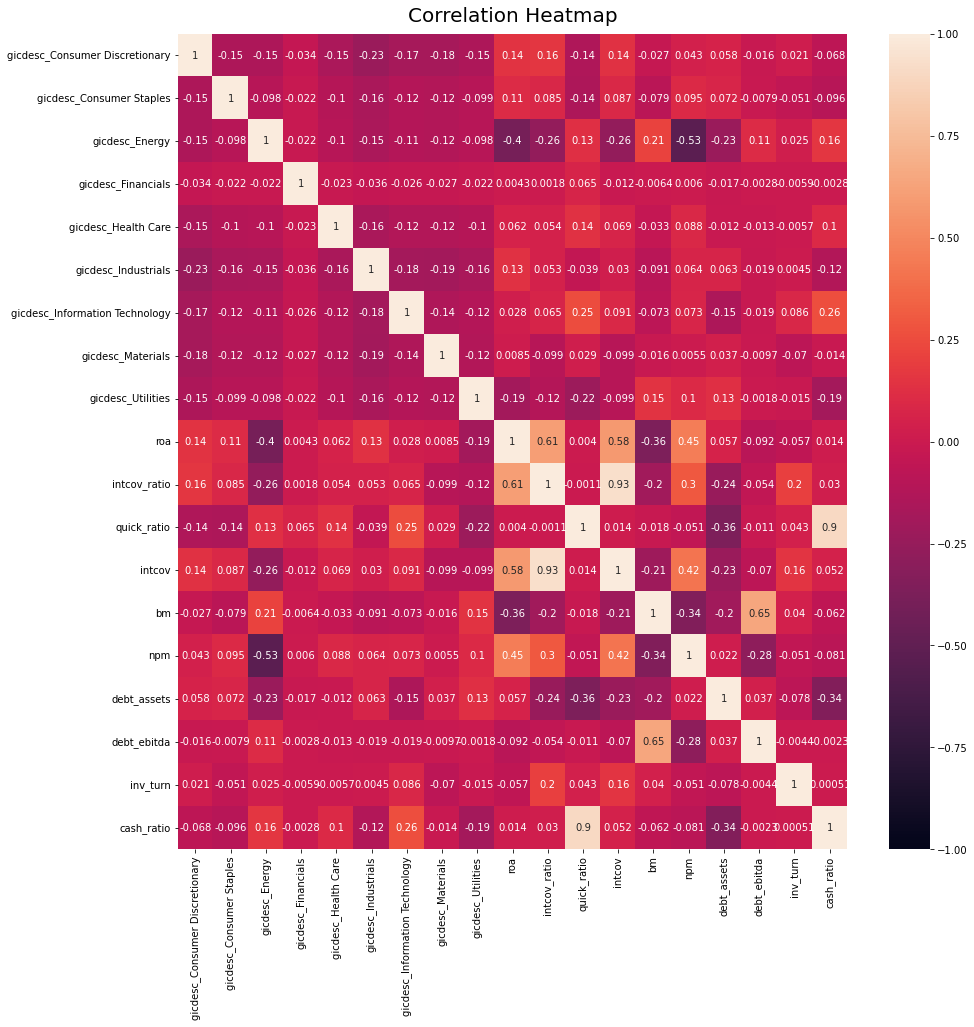

In [5]:
corr = all_data[columnsOfInterest].corr()
plt.figure(figsize=(15, 15))
heatmap = sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=12)

#### Lasso for Feature Selection

##### Lasso Regression and Select Non-Zero Coefficients

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_lasso = scaler.fit_transform(X_train)
X_test_lasso = scaler.transform(X_test)

from sklearn.linear_model import LassoCV

clf = LassoCV().fit(X_train_lasso, y_train)

selectedFeatures = []
print("Columns selected are : ")
for i in range(len(clf.coef_)):
    if clf.coef_[i] != 0:
        print(columnsOfInterest[i])
        selectedFeatures.append(i)

print("\n\nColumns dropped are : ")
for i in range(len(clf.coef_)):
    if clf.coef_[i] == 0:
        print(columnsOfInterest[i])

Columns selected are : 
gicdesc_Consumer Discretionary
gicdesc_Energy
gicdesc_Health Care
gicdesc_Industrials
gicdesc_Information Technology
gicdesc_Materials
gicdesc_Utilities
roa
intcov_ratio
quick_ratio
bm
npm
debt_assets
debt_ebitda
inv_turn
cash_ratio


Columns dropped are : 
gicdesc_Consumer Staples
gicdesc_Financials
intcov


##### Plot the Coefficients

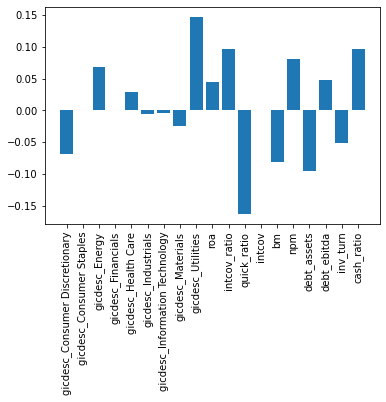

In [7]:
plt.bar(columnsOfInterest, clf.coef_)
plt.xticks(rotation=90)
plt.show()

#### PCA

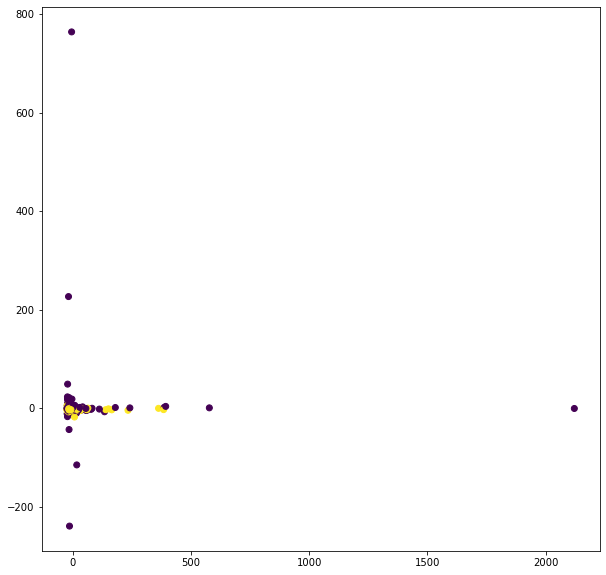

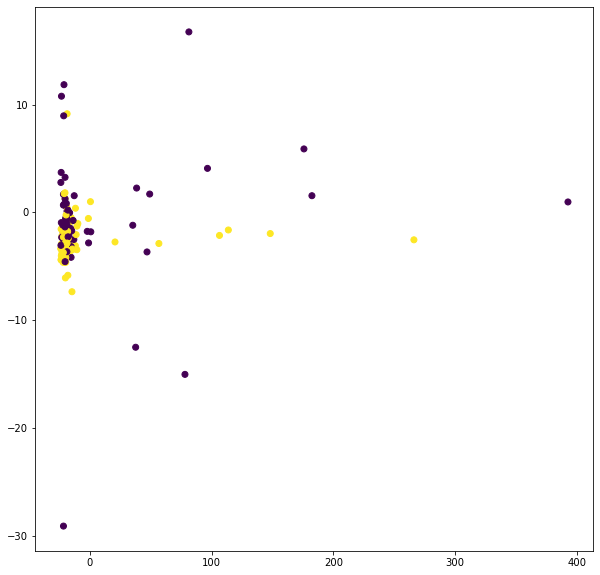

In [8]:
# Do pca, plot the first two principal components
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X_train)
X_train2 = pca.transform(X_train)
X_test2 = pca.transform(X_test)

plt.figure(figsize=(10, 10))
plt.scatter(X_train2[:, 0], X_train2[:, 1], c=y_train)
plt.show()

# Pca plot for test data
plt.figure(figsize=(10, 10))
plt.scatter(X_test2[:, 0], X_test2[:, 1], c=y_test)
plt.show()

#### Change X_train and X_test to Only Columns of Interest

In [9]:
selectedFeatures_names = [columnsOfInterest[i] for i in selectedFeatures]

X_train = X_train[selectedFeatures_names]
X_test = X_test[selectedFeatures_names]

X_train

,gicdesc_Consumer Discretionary,gicdesc_Energy,gicdesc_Health Care,gicdesc_Industrials,gicdesc_Information Technology,gicdesc_Materials,gicdesc_Utilities,roa,intcov_ratio,quick_ratio,bm,npm,debt_assets,debt_ebitda,inv_turn,cash_ratio
29,0,1,0,0,0,0,0,0.101847,3.551547,5.029421,3.806594,0.270987,0.316093,2.864391,3.067427,2.555697
666,0,0,0,0,0,1,0,0.020332,-2.309417,1.155721,1.158963,-0.191355,0.508770,7.633208,5.351364,0.744882
444,0,0,0,1,0,0,0,0.184457,6.121827,0.818182,0.217611,0.086854,0.744954,2.445495,92.219780,0.011453
173,0,1,0,0,0,0,0,0.069970,-4.314494,4.188895,0.691222,-0.068733,0.326807,1.046907,6.737834,2.851304
694,0,0,0,0,0,0,0,0.110725,3.029511,0.930641,0.320311,0.066988,0.748901,4.811916,3.087314,0.185050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,0,0,0,0,0,0,1,0.067478,2.946752,1.316525,0.837092,0.157120,0.656931,4.254503,7.352066,0.246201
208,0,0,0,1,0,0,0,0.130606,8.304481,0.665502,0.594001,0.204824,0.500482,2.211691,8.355938,0.229178
107,0,0,0,1,0,0,0,0.234242,17.050847,0.845159,0.277916,0.124053,0.596688,1.607813,11.937366,0.184212
324,0,0,0,0,0,1,0,0.161669,7.609300,1.215966,0.304566,0.059887,0.603715,1.639511,9.601169,0.320485


### Functions for Statistics

#### Function to Create a Confusion Matrix

In [10]:
def create_confusion_matrix(test_vals, pred_vals, model_name):
    conf_mat = confusion_matrix(test_vals, pred_vals)
    sns.heatmap(conf_mat, annot=True, cmap='Blues')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    
    #Change the 0's and 1's to the actual class names for clearer interpretation
    plt.xticks(ticks=[0.5,1.5], labels=['Sub-Investment Grade','Investment Grade'])
    plt.yticks(ticks=[0.5,1.5], labels=['Sub-Investment Grade','Investment Grade'])
    plt.title('Confusion Matrix for {} Model'.format(model_name))

#### Function to Create ROC Curve

In [11]:
def create_roc_curve(model, x_test, y_test, model_name):
    metrics.plot_roc_curve(model, x_test, y_test, name=model_name)
    plt.plot([0,1],[0,1], linestyle='--', label='Baseline Classifier',color = 'red')
    plt.grid()
    plt.legend()

#### Function to Create PR Curve

In [12]:
def create_pr_curve(model, x_test, y_test, model_name):
    metrics.plot_precision_recall_curve(model, x_test, y_test, name=model_name)
    positive_rate = sum(y_test)/len(y_test)
    plt.plot([0,1],[positive_rate,positive_rate], linestyle='--', label='Baseline Classifier',color = 'red')
    plt.grid()
    plt.legend()

### Logistic Regression

#### Create Model (Sklearn)

In [13]:
model = LogisticRegression(max_iter=1000)

result = model.fit(X_train, y_train)

In [14]:
y_pred = model.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.5f}'.format(model.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.78378


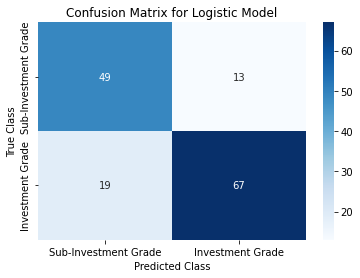

In [15]:
create_confusion_matrix(y_test, y_pred,'Logistic')

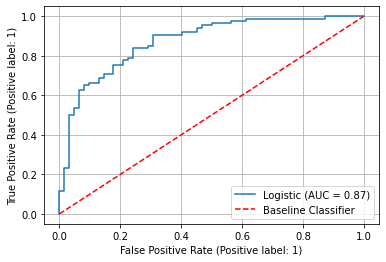

In [16]:
create_roc_curve(model, X_test, y_test, 'Logistic')

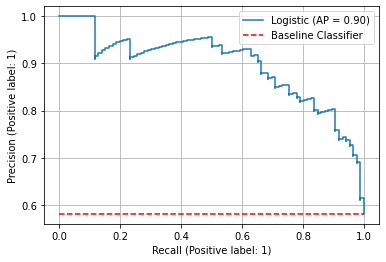

In [17]:
create_pr_curve(model, X_test, y_test, 'Logistic')

#### Create Model Statsmodels

In [18]:
import statsmodels.formula.api as smf

train = X_train.copy()
train['rating'] = y_train

formula_format = ''
for i in X_train.columns :
  formula_format += 'Q("' + i + '") + '

m1 = smf.logit(
  formula='rating ~ ' + formula_format[:-2],
  data=train) \
.fit()

m1.summary()

Optimization terminated successfully.
         Current function value: 0.489559
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 rating   No. Observations:                  441
Model:                          Logit   Df Residuals:                      424
Method:                           MLE   Df Model:                           16
Date:                Thu, 03 Nov 2022   Pseudo R-squ.:                  0.2931
Time:                        18:51:10   Log-Likelihood:                -215.90
converged:                       True   LL-Null:                       -305.42
Covariance Type:            nonrobust   LLR p-value:                 1.303e-29
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               3.7565      1.209      3.108      0.002       1.387       6.126
Q("gicdesc_Consumer Discretionary")    -0.9855      0.440     -2.239      0.025      -1.848      -0.123
Q("gicdesc_Energy")                     1.9016      0.676      2.815      0.005       0.577       3.226
Q("gicdesc_Health Care")                0.5011      0.552      0.908      0.364      -0.580       1.582
Q("gicdesc_Industrials")               -0.2645      0.425     -0.622      0.534      -1.098       0.569
Q("gicdesc_Information Technology")    -0.1648      0.491     -0.336      0.737      -1.127       0.797
Q("gicdesc_Materials")                 -0.3478      0.462     -0.753      0.452      -1.254       0.558
Q("gicdesc_Utilities")                  3.7980      0.848      4.476      0.000       2.135       5.461
Q("roa")                               -0.7255      3.193     -0.227      0.820      -6.984       5.533
Q("intcov_ratio")                       0.1028      0.030      3.442      0.001       0.044       0.161
Q("quick_ratio")                       -1.0711      0.377     -2.838      0.005      -1.811      -0.331
Q("bm")                                -1.5638      0.525     -2.978      0.003      -2.593      -0.535
Q("npm")                                3.8776      1.486      2.609      0.009       0.965       6.790
Q("debt_assets")                       -4.1080      1.181     -3.479      0.001      -6.422      -1.794
Q("debt_ebitda")                       -0.0015      0.008     -0.184      0.854      -0.017       0.014
Q("inv_turn")                          -0.0042      0.001     -2.936      0.003      -0.007      -0.001
Q("cash_ratio")                         0.6754      0.403      1.675      0.094      -0.115       1.466
=======================================================================================================
"""

In [19]:
from sklearn.metrics import accuracy_score

y_pred = m1.predict(X_test)
prediction = list(map(round, y_pred))
  
# confusion matrix
cm = metrics.confusion_matrix(y_test, prediction) 
print ("Confusion Matrix : \n", cm) 
  
# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_test, prediction))

Confusion Matrix : 
 [[49 13]
 [16 70]]
Test accuracy =  0.8040540540540541


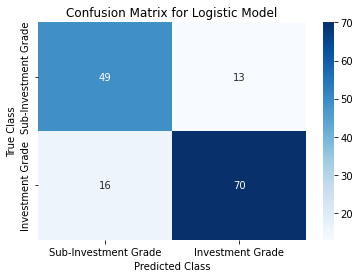

In [20]:
create_confusion_matrix(y_test, prediction,'Logistic')

### KNN

In [21]:
knn_results = {}

for k in range(1,26):
    knn = KNeighborsClassifier(n_neighbors = k)

    knn.fit(X_train, y_train)
    knn.predict(X_test)
    
    knn_results[k] = knn.score(X_test, y_test)

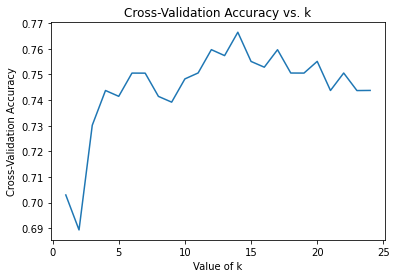

In [22]:
knn_results = []
for k in range(1,25):
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    knn_results.append(scores.mean())

plt.plot(range(1,25), knn_results)
plt.xlabel('Value of k')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Cross-Validation Accuracy vs. k')
plt.show()

In [23]:
knn_final = KNeighborsClassifier(n_neighbors = 14)
knn_final.fit(X_train,y_train)
knn_final_pred = knn_final.predict(X_test)
knn_final.score(X_test,y_test)

0.722972972972973

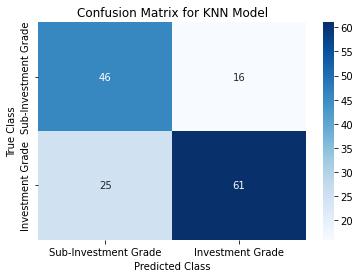

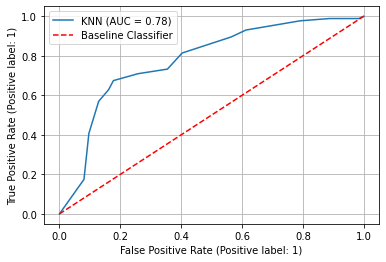

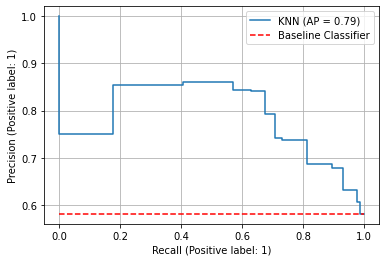

In [24]:
create_confusion_matrix(y_test, knn_final_pred,'KNN')
create_roc_curve(knn_final, X_test, y_test, 'KNN')
create_pr_curve(knn_final, X_test, y_test, 'KNN')

### Decision Trees

In [25]:
#Fit a basic decision tree model
tree_mod = DecisionTreeClassifier(max_depth=3,random_state=1)
tree_mod.fit(X_train,y_train)
tree_mod_pred = tree_mod.predict(X_test)
tree_mod.score(X_test,y_test)

0.7702702702702703

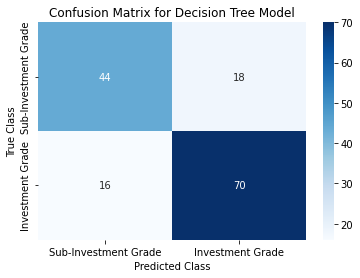

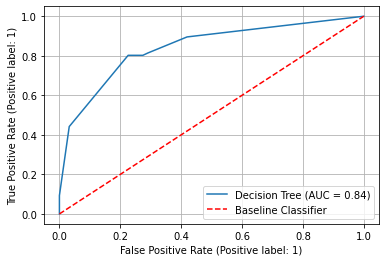

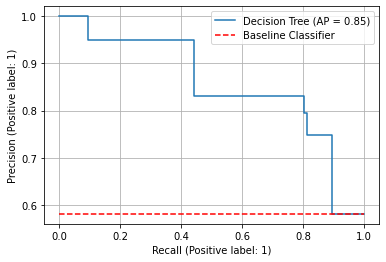

In [26]:
create_confusion_matrix(y_test, tree_mod_pred,'Decision Tree')
create_roc_curve(tree_mod, X_test, y_test, 'Decision Tree')
create_pr_curve(tree_mod, X_test, y_test, 'Decision Tree')

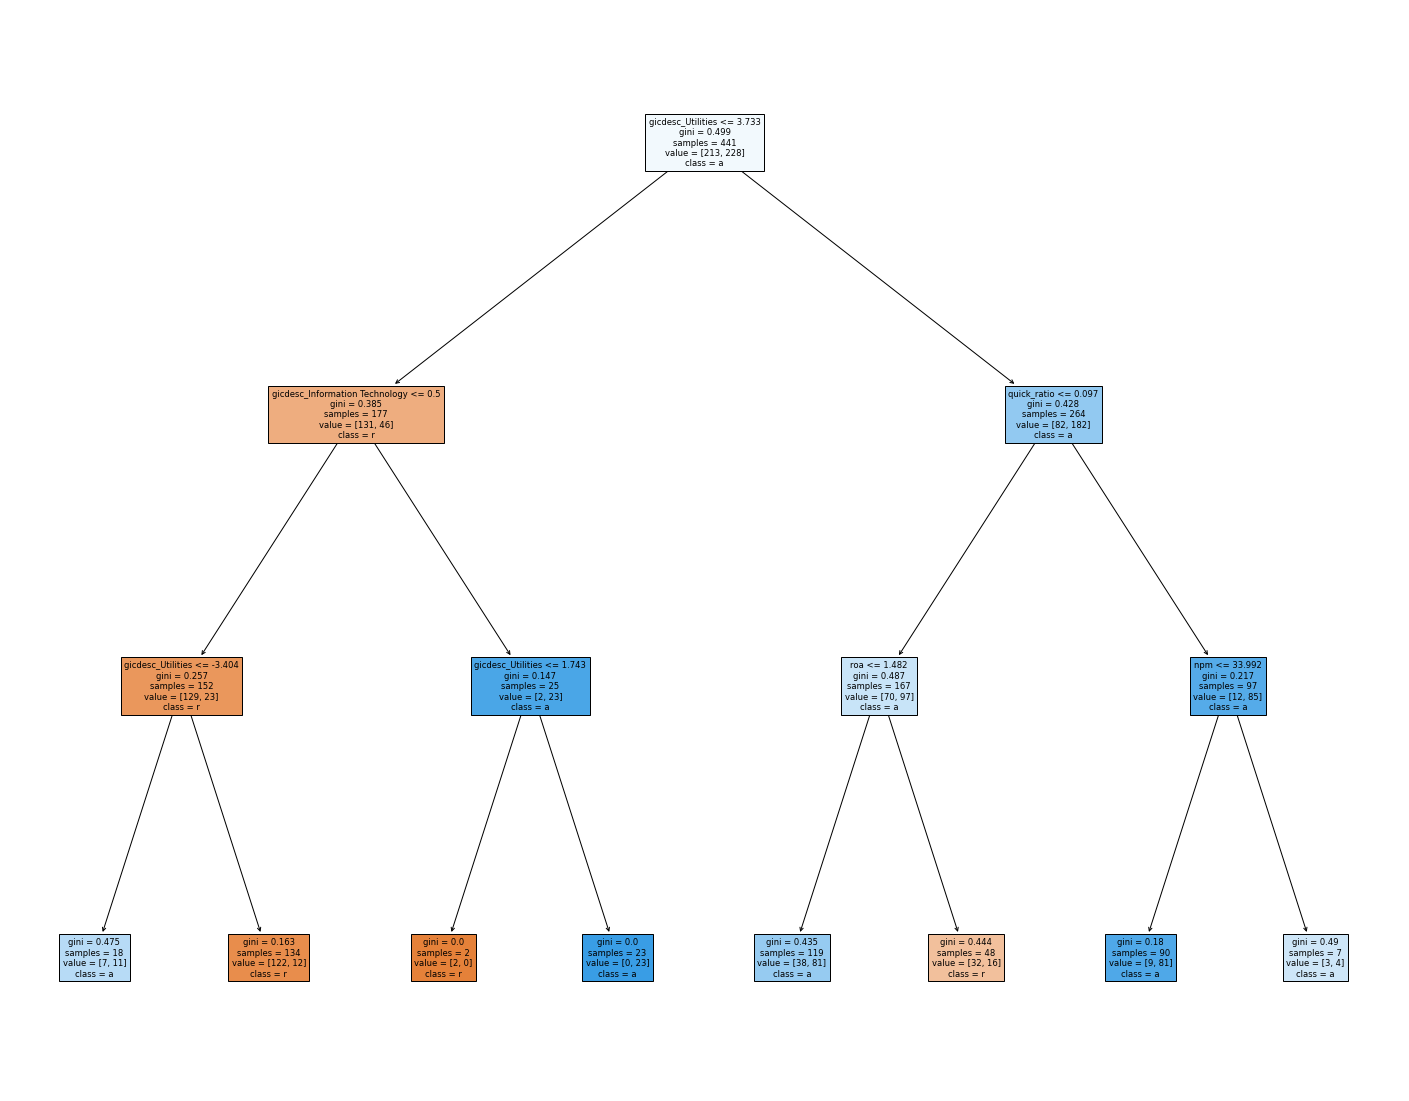

In [27]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(tree_mod, 
                   feature_names=columnsOfInterest,  
                   class_names='rating',
                   filled=True)

In [28]:
n_estimators = [100,150,200,250,300] 
max_depth = [2,3,4,5,6] 
grid = {'n_estimators': n_estimators, 'max_depth': max_depth}
rf_mod_tuned = RandomForestClassifier(random_state=1)
rf_mod_tuned = GridSearchCV(estimator = rf_mod_tuned, param_grid = grid,
               cv = 5, verbose=2, n_jobs = -1)
rf_mod_tuned_fitted = rf_mod_tuned.fit(X_train,y_train)
rf_mod_tuned_pred = rf_mod_tuned_fitted.predict(X_test)
rf_mod_tuned_fitted.score(X_test,y_test)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


0.831081081081081

In [29]:
rf_mod_tuned.best_params_

{'max_depth': 6, 'n_estimators': 100}

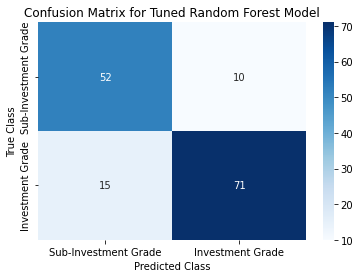

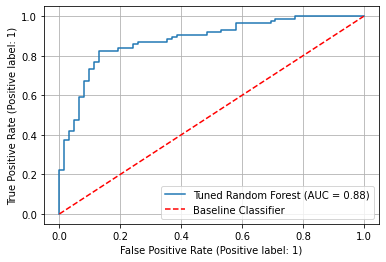

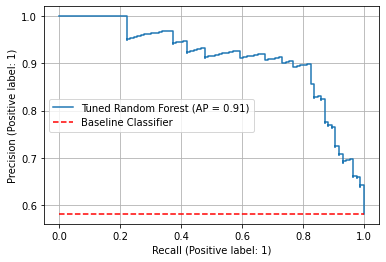

In [30]:
create_confusion_matrix(y_test, rf_mod_tuned_pred,'Tuned Random Forest')
create_roc_curve(rf_mod_tuned_fitted, X_test, y_test, 'Tuned Random Forest')
create_pr_curve(rf_mod_tuned_fitted, X_test, y_test, 'Tuned Random Forest')

Text(0.5, 1.0, 'Feature Importance vs. Feature')

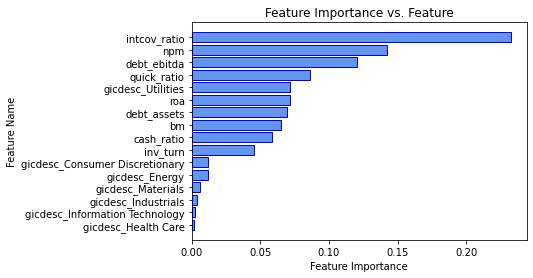

In [31]:
imp_scores = rf_mod_tuned_fitted.best_estimator_.feature_importances_
selectedFeatures_names = [columnsOfInterest[i] for i in selectedFeatures]
sorted_idx = imp_scores.argsort()
plt.barh([selectedFeatures_names[i] for i in sorted_idx],imp_scores[sorted_idx],color='cornflowerblue',edgecolor='blue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance vs. Feature')